In [1]:
import mediapipe as mp
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
import torch.utils as utils
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [3]:
classes = ("down", "up", "stop", "thumbright", "thumbleft", "right", "left", "background")

In [4]:
hands = mp_hands.Hands(min_detection_confidence=0.6, min_tracking_confidence=0.3, static_image_mode=True, max_num_hands=1)

In [5]:
train_data = []
train_labels = []

for class_index, gesture_class in enumerate(classes):
    for i in range(175):
        try:
            image = cv2.imread(f"../training/{gesture_class}.{i}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # changes from bgr to rgb since cv2 is bgr but mediapipe requires rgb
        except:
            continue
        image.flags.writeable = False
        results = hands.process(image) # this makes the actual detections
        
        landmarks = []
        if results.multi_hand_landmarks:
            for landmark in results.multi_hand_landmarks[0].landmark:
                x, y = landmark.x, landmark.y
                landmarks.append([x,y])
            train_label = np.zeros([len(classes)])
            train_label[class_index] = 1
            train_data.append(landmarks)
            train_labels.append(train_label)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
[ WARN:0@15.644] global loadsave.cpp:248 findDecoder imread_('../training/down.100.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.647] global loadsave.cpp:248 findDecoder imread_('../training/down.101.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.647] global loadsave.cpp:248 findDecoder imread_('../training/down.102.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.647] global loadsave.cpp:248 findDecoder imread_('../training/down.103.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.647] global loadsave.cpp:248 findDecoder imread_('../training/down.104.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.647] global loadsave.cpp:248 findDecoder imread_('../training/down.105.jpg'): can't open/read file: check file path/integrity
[ WARN:0@15.647] global loadsave.cpp:248 findDecoder imread_('../training/down.106.jpg'): can't open/read file: chec

In [6]:
train_data = torch.tensor(train_data)
train_labels = torch.tensor(train_labels)

/var/folders/xw/slcw2lz14snfvxp49xgqmr880000gn/T/ipykernel_15404/3266268609.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/torch/csrc/utils/tensor_new.cpp:264.)
  train_labels = torch.tensor(train_labels)


In [7]:
train_data.shape

torch.Size([785, 21, 2])

In [8]:
class LandmarksDataset(utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.len = len(y)
        self.transform = transform
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
training_set = LandmarksDataset(train_data, train_labels)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)

In [10]:
val_data = []
val_labels = []
for class_index, gesture_class in enumerate(classes):
    for i in range(40):
        image = cv2.imread(f"../validation/{gesture_class}.{i}.jpg")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # changes from bgr to rgb since cv2 is bgr but mediapipe requires rgb
        image.flags.writeable = False
        results = hands.process(image) # this makes the actual detections
        
        landmarks = []
        if results.multi_hand_landmarks:
            for landmark in results.multi_hand_landmarks[0].landmark:
                x, y = landmark.x, landmark.y
                landmarks.append([x,y])
            val_label = np.zeros([len(classes)])
            val_label[class_index] = 1
            val_data.append(landmarks)
            val_labels.append(val_label)

In [11]:
val_data = torch.tensor(val_data)
val_labels = torch.tensor(val_labels)

In [12]:
validation_set = LandmarksDataset(val_data, val_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

In [13]:
val_data.shape

torch.Size([310, 21, 2])

In [17]:
class HandNetwork(nn.Module):
    def __init__(self):
        super(HandNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.LeakyReLU()
        self.fc1 = nn.Linear(42, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, len(classes))
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [22]:
model = HandNetwork()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)

In [23]:
def train_one_epoch(curr_model):
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = curr_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward() # calculate the gradients
        optimizer.step() # update the params

        running_loss += loss.item()
        if i % 10 == 10-1:
            last_loss = running_loss / 10 # loss per batch
            print(f'  batch {i+1} loss: {last_loss}')
            running_loss = 0
    
    return last_loss

EPOCH 1:
  batch 10 loss: 2.081457620859146
  batch 20 loss: 2.0688407838344576
  batch 30 loss: 2.0353876769542696
  batch 40 loss: 2.08460813164711
  batch 50 loss: 2.0626399725675584
  batch 60 loss: 2.099316856265068
  batch 70 loss: 2.0558640241622923
  batch 80 loss: 2.0721993893384933
  batch 90 loss: 2.0843223571777343
  batch 100 loss: 2.074992221593857
  batch 110 loss: 2.0453262120485305
  batch 120 loss: 2.0834028840065004
  batch 130 loss: 2.041154000163078
  batch 140 loss: 2.047263702750206
  batch 150 loss: 2.0400151938199995
  batch 160 loss: 2.0504810363054276
  batch 170 loss: 2.0422505706548693
  batch 180 loss: 2.002999100089073
  batch 190 loss: 2.044433891773224
LOSS train 2.044433891773224 valid 2.084791893760363
EPOCH 2:
  batch 10 loss: 2.061880576610565
  batch 20 loss: 2.0585823982954023
  batch 30 loss: 2.0669133365154266
  batch 40 loss: 2.050375735759735
  batch 50 loss: 1.9722982108592988
  batch 60 loss: 2.01523971259594
  batch 70 loss: 2.0736432611942

Text(0, 0.5, 'Validation Loss')

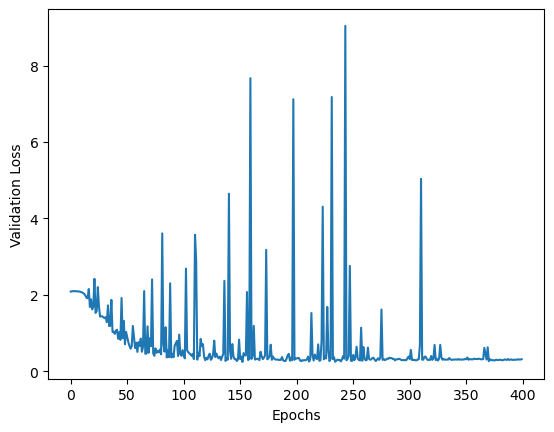

In [24]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

#This is doing some logging that we don't need to worry about right now.
epoch_number = 0
EPOCHS = 400
best_vloss = 1_000_000.
val_history = []
best_model = model

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    model.train(True)
    
    avg_loss = train_one_epoch(curr_model=model)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    val_history.append(avg_vloss.detach().numpy())
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        torch.save(model, "../models/model9.pth")
    epoch_number += 1

plt.plot(range(EPOCHS), val_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

In [25]:
best_vloss

tensor(0.2432, dtype=torch.float64, grad_fn=<DivBackward0>)

In [882]:
import torch.nn.functional as F
from sklearn.metrics import f1_score

In [883]:
model = torch.load("../models/model9.pth")

In [884]:
model.eval()
correct_count = 0
total = len(validation_set)
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        inputs, labels = vdata
        outputs = torch.argmax(model(inputs), dim=1)
        labels = torch.argmax(labels, dim=1)
        correct_count += (outputs==labels).sum().item()

In [885]:
correct_count/total

0.9741935483870968

In [886]:
f1_score(np.argmax(model(val_data).detach().numpy(), axis=1), np.argmax(val_labels.detach().numpy(), axis=1), average='micro')

0.9741935483870968

from sklearn.neighbors import KNeighborsClassifier

In [586]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [587]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data.view(-1,21*2), train_labels)
y_pred = knn.predict(val_data.view(-1,21*2))
accuracy_score(val_labels, y_pred)

0.5580645161290323

In [588]:
from sklearn.linear_model import RidgeClassifierCV

In [589]:
train_data.shape

torch.Size([699, 21, 2])

In [590]:
clf = RidgeClassifierCV()
clf.fit(train_data.view(-1, 21*2), train_labels)
y_pred = clf.predict(val_data.view(-1, 21*2))
accuracy_score(val_labels, y_pred)

0.5193548387096775

In [591]:
F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))))

/var/folders/xw/slcw2lz14snfvxp49xgqmr880000gn/T/ipykernel_86164/1044316036.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))))


tensor([[0.4573, 0.0484, 0.0896,  ..., 0.0850, 0.0911, 0.0797],
        [0.4173, 0.0532, 0.1257,  ..., 0.0936, 0.0882, 0.0599],
        [0.4564, 0.0462, 0.0918,  ..., 0.0855, 0.0899, 0.0812],
        ...,
        [0.0744, 0.0594, 0.1351,  ..., 0.1360, 0.1033, 0.1548],
        [0.0907, 0.0860, 0.1948,  ..., 0.1134, 0.1084, 0.0952],
        [0.0876, 0.0802, 0.1651,  ..., 0.1132, 0.1127, 0.1029]],
       dtype=torch.float64)

In [592]:
clf.score(val_data.view(-1, 21*2), val_labels)

0.5193548387096775

In [593]:
from sklearn.svm import LinearSVC

In [111]:
clf = LinearSVC(multi_class="ovr")
clf.fit(train_data.view(-1, 21*2), torch.argmax(train_labels, dim=1))
clf.score(val_data.view(-1, 21*2), torch.argmax(val_labels, dim=1))

/Users/reetinav/anaconda3/envs/PIC16B/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8888888888888888

In [112]:
F.softmax(torch.tensor(clf.decision_function(val_data.view(-1, 21*2))), dim=1)

tensor([[0.5952, 0.0090, 0.0528,  ..., 0.0620, 0.0913, 0.0809],
        [0.5499, 0.0127, 0.0850,  ..., 0.0669, 0.0768, 0.0737],
        [0.5842, 0.0089, 0.0531,  ..., 0.0594, 0.0923, 0.0878],
        ...,
        [0.0690, 0.1502, 0.1629,  ..., 0.1562, 0.0389, 0.0815],
        [0.0903, 0.0719, 0.4556,  ..., 0.0353, 0.1396, 0.1260],
        [0.0648, 0.0662, 0.5327,  ..., 0.0554, 0.0969, 0.1004]],
       dtype=torch.float64)